In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import linear_model
import statsmodels.formula.api as smf
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
df = pd.read_csv('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.csv')

In [3]:
df.columns = df.columns.str.replace('\n', ' ')
df.drop(['Unnamed: 13'], axis=1, inplace=True)
df.columns

Index(['City', 'Population', 'Violent crime',
       'Murder and nonnegligent manslaughter', 'Rape (revised definition)1',
       'Rape (legacy definition)2', 'Robbery', 'Aggravated assault',
       'Property crime', 'Burglary', 'Larceny- theft', 'Motor vehicle theft',
       'Arson3'],
      dtype='object')

In [4]:
fix = ['Population', 'Violent crime', 'Rape (legacy definition)2', 'Robbery', 'Aggravated assault', 
       'Property crime', 'Burglary', 'Larceny- theft', 'Motor vehicle theft']
#fixing commas in the numeric columns
for key in fix:
    df[key] = pd.to_numeric(df[key].astype(str).str.replace(',',''), errors='ignore')


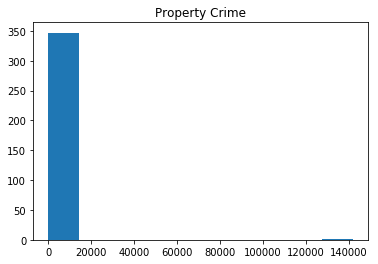

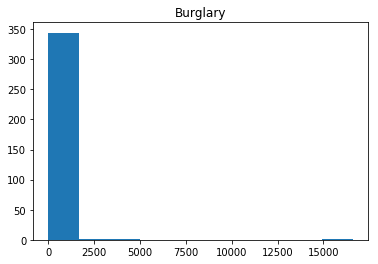

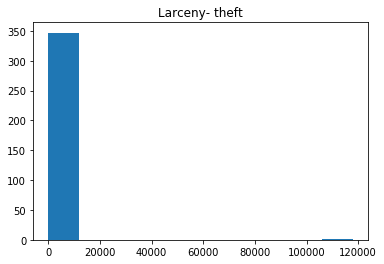

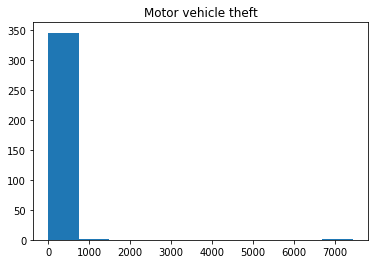

In [5]:
for key in fix:
    df[key] = pd.to_numeric(df[key].astype(str).str.replace(',',''), errors='coerce')
df.dropna(axis=1, how='all', inplace=True)
df.dropna(axis=0, how='all', inplace=True)
#Use to make sure all the values are now numerical
#df.dtypes
plt.title("Property Crime")
plt.hist(df['Property crime'])
plt.show()
keys = ['Burglary', 'Larceny- theft', 'Motor vehicle theft']
for key in keys:
    plt.title(key)
    plt.hist(df[key])  
    plt.show()

In [8]:
#Nans in the data source mean that arson data wasn't complete and not included
#Property crime = Burglary + Larceny + Motor Theft + Arson
df['Arson3'] = df['Arson3'].replace(np.nan, 0)


In [7]:
#detecting outliers
display(df.loc[df['Property crime']>4000, :])
df.drop(df[df['Property crime']>4000].index, inplace=True)

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
3,Albany,97956.000,791.000,8.000,30.000,227.000,526.000,4090.000,705.000,3243.000,142.000,0.000
35,Buffalo,258789.000,3249.000,47.000,145.000,1322.000,1735.000,12491.000,3458.000,8076.000,957.000,0.000
216,New York,8396126.000,52384.000,335.000,1112.000,19170.000,31767.000,141971.000,16606.000,117931.000,7434.000,0.000
272,Rochester,210562.000,2107.000,42.000,92.000,918.000,1055.000,10051.000,2587.000,6855.000,609.000,132.000
310,Syracuse,143834.000,1192.000,21.000,75.000,400.000,696.000,6473.000,1781.000,4298.000,394.000,57.000


In [7]:
#PCA for burg, larceny, motor theft, and arson
#attempting to combine the property crime components, but not included so far in the analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
df_pca = df[['Burglary', 'Larceny- theft', 'Motor vehicle theft', 'Arson3']].dropna()
standard = StandardScaler().fit_transform(df_pca)
Xt = standard.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

In [8]:
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 4).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')
#only keep first one

Eigenvector 1: 
[[0.54722266]
 [0.51863811]
 [0.52156169]
 [0.39941867]]
Eigenvalue 1: 2.898094139148601
----------------------------------------
Eigenvector 2: 
[[ 0.27866302]
 [ 0.36819364]
 [ 0.02059475]
 [-0.88676729]]
Eigenvalue 2: 0.6657934682682961
----------------------------------------
Eigenvector 3: 
[[-0.78529533]
 [ 0.54668949]
 [ 0.29029592]
 [-0.01304355]]
Eigenvalue 3: 0.13208551185555426
----------------------------------------
Eigenvector 4: 
[[ 0.07877523]
 [ 0.54459026]
 [-0.80204584]
 [ 0.23224637]]
Eigenvalue 4: 0.3158612002541723
----------------------------------------


In [9]:
P = eig_vec_cov[:, 0]
result = P.T.dot(Xt)

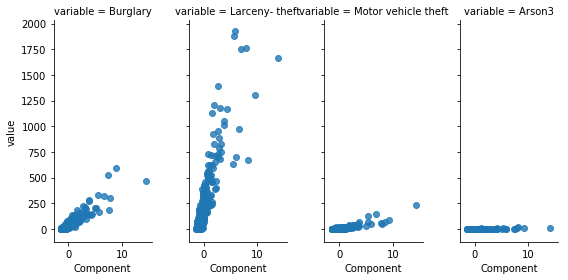

In [10]:
data_to_plot = df_pca[['Burglary', 'Larceny- theft', 'Motor vehicle theft', 'Arson3']]
data_to_plot['Component'] = result
data_to_plot = pd.melt(data_to_plot, id_vars='Component')

g = sns.FacetGrid(data_to_plot, col="variable", height=4, aspect=.5)
g = g.map(
    sns.regplot,
    "Component",
    "value",
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
plt.show()

In [11]:
sklearn_pca = PCA(n_components=4)
Y_sklearn = sklearn_pca.fit_transform(standard)
sklearn_pca.explained_variance_ratio_
sklearn_pca
#end PCA attempt

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [25]:
df['Arson3'].fillna(0, inplace=True)
df['Population^2'] = df['Population'].map(lambda x: x**2)
df['Murder'] = np.where(df['Murder and nonnegligent manslaughter']>0, 1, 0)
df['Robbery_feature'] = np.where(df['Robbery']>0, 1, 0)
df['Arson_data'] = np.where(df['Arson3']>0, 1, 0)
df['High_theft'] = np.where(
    (df['Larceny- theft']>0) & (df['Burglary']>0)
    , 1, 0)
df['Burg_bool'] = np.where(df['Burglary']>0, 1,0)
df['Danger_zone'] = np.where((df['Murder and nonnegligent manslaughter']>0) & (df['Violent crime']>0), 1, 0)
df['Violence'] = np.where(df['Violent crime']>0, 1, 0)


City                                    317
Population                              317
Violent crime                           317
Murder and nonnegligent manslaughter    317
Rape (legacy definition)2               317
Robbery                                 317
Aggravated assault                      317
Property crime                          317
Burglary                                317
Larceny- theft                          317
Motor vehicle theft                     317
Arson3                                  317
Population^2                            317
Murder                                  317
Robbery_feature                         317
Arson_data                              317
High_theft                              317
Burg_bool                               317
Danger_zone                             317
Violence                                317
dtype: int64

In [28]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df['Property crime'].values.reshape(-1, 1)
X = df[['Population^2',  'Robbery_feature', 'Danger_zone', 'High_theft', 'Arson3', 'Burglary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 2.82546918e-08  1.01759145e+02  2.43588329e+01  1.16144521e+01
  -2.56015150e+00  4.15271112e+00]]

Intercept: 
 [3.15357832]

R-squared:
0.845568943049876


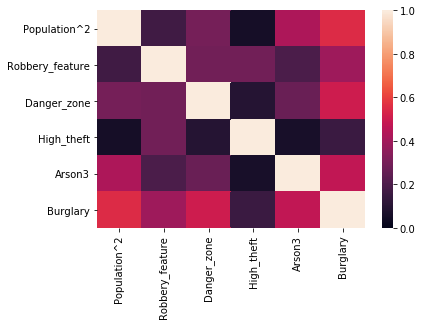

In [29]:
sns.heatmap(X.corr(), vmin=0, vmax=1)
plt.show()

# Multivariate normality check

In [ ]:
actual = df['Property crime']
predicted = regr.predict(X).ravel()
residual = predicted-actual

plt.figure(figsize=(10,5))
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [ ]:
display(df.loc[np.abs(residual)>250])
df.drop(df[np.abs(residual)>250].index, inplace=True)

In [ ]:
actual = df['Property crime']
X = df[['Population^2', 'Murder', 'Robbery_feature', 'Arson_data', 'Motor_theft', 'Burglary']]
predicted = regr.predict(X).ravel()
residual = predicted-actual

plt.figure(figsize=(10,5))
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# Homoscadasticity check

In [ ]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [ ]:
df['Property crime'] = df['Property crime'].map(lambda x: x**2)

In [ ]:
actual = df['Property crime']
X = df[['Population^2', 'Murder', 'Robbery_feature', 'Arson_data', 'Motor_theft', 'Burglary']]
predicted = regr.predict(X).ravel()
residual = predicted-actual
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [ ]:
display(X.corr())